# Understating why in RxInfer to initialize messages or marginals

In certain models, after completing the model specification step and moving on to execute the inference procedure, you may encounter an error prompting you to "initialize marginals and messages." Understanding why this step is necessary can be perplexing. This tutorial is designed to delve into the intuition behind model initialization using a practical example.

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/repos/biaslab/RxInfer.jl/examples`


┌ Warning: The active manifest file has dependencies that were resolved with a different julia version (1.9.3). Unexpected behavior may occur.
└ @ nothing /Users/mykola/repos/biaslab/RxInfer.jl/examples/Manifest.toml:0
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API /Users/mykola/.julia/juliaup/julia-1.10.0+0.aarch64.apple.darwin14/share/julia/stdlib/v1.10/Pkg/src/API.jl:1800


Pkg.Types.PkgError: `BayesBase` is a direct dependency, but does not appear in the manifest. If you intend `BayesBase` to be a direct dependency, run `Pkg.resolve()` to populate the manifest. Otherwise, remove `BayesBase` with `Pkg.rm("BayesBase")`. Finally, run `Pkg.instantiate()` again.

In [19]:
using RxInfer, Random, Plots, StableRNGs, LinearAlgebra, StatsPlots, LaTeXStrings, DataFrames, CSV, GLM

## Part 1. Framing the problem 

John has recently acquired a new car and is keenly interested in its `fuel consumption` rate. He holds the belief that this rate follows a linear relationship with the variable `speed`. To validate this hypothesis, he plans to conduct tests by driving his car on the urban roads close to his home, meticulously recording both the `fuel consumption` and `speed` data. To ascertain the fuel consumption rate, John has opted for Bayesian linear regression as his analytical method.

In [20]:
function generate_data(a, b, v, nr_samples; rng=StableRNG(1234))
    x = float.(collect(1:nr_samples))
    y = a .* x .+ b .+ randn(rng, nr_samples) .* sqrt(v)
    return x, y
end;

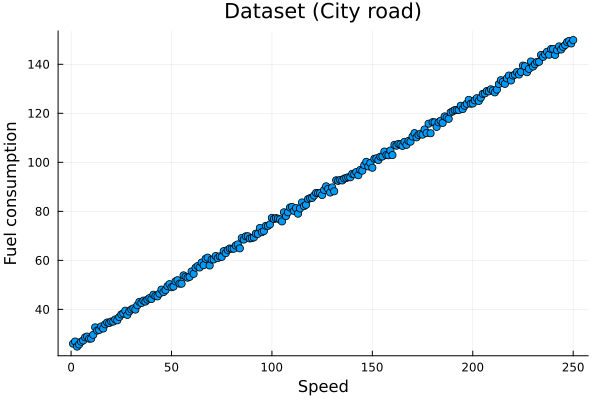

In [21]:
x_data, y_data = generate_data(0.5, 25.0, 1.0, 250)

scatter(x_data, y_data, title = "Dataset (City road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

### Univariate regression with known noise

First, he drives the car on a urban road. John enjoys driving on the well-built, wide, and flat urban roads. Urban roads also offer the advantage of precise fuel consumption measurement with minimal noise. Therefore John models the fuel consumption $y_n\in\mathbb{R}$ as a normal distribution and treats $x_n$ as a fixed hyper-parameter:

$$\begin{aligned}
p(y_n \mid a, b) = \mathcal{N}(y_n \mid a x_n + b , 1)
\end{aligned}$$

The recorded speed is denoted as $x_n \in \mathbb{R}$ and the recorded fuel consumption as $y_n \in \mathbb{R}$. Prior beliefs on $a$ and $b$ are informed by the vehicle manual.

$$\begin{aligned}
    p(a) &= \mathcal{N}(a \mid m_a, v_a) \\
    p(b) &= \mathcal{N}(b \mid m_b, v_b) 
\end{aligned}$$

Together they form the probabilistic model
$$p(y, a, b) = p(a)p(b) \prod_{N=1}^N p(y_n \mid a, b),$$
where the goal is to infer the posterior distributions $p(a \mid y)$ and $p(b\mid y)$.

In order to estimate the two parameters with the recorded data, he uses a `RxInfer.jl` to create the above described model.

In [22]:
@model function linear_regression(nr_samples)
    a ~ Normal(mean = 0.0, variance = 1.0)
    b ~ Normal(mean = 0.0, variance = 100.0)
    
    x = datavar(Float64, nr_samples)
    y = datavar(Float64, nr_samples)
    
    y .~ Normal(mean = a .* x .+ b, variance = 1.0)
end

Delighted with the convenience offered by the package's inference function (infer), he appreciates the time saved from building everything from the ground up. This feature allows him to effortlessly obtain the desired results for his specific road. Upon consulting the documentation, he proceeds to run the inference function. However, being his first attempt, he overlooks the `initmessages` argument as he doesn't know what to initialize.  After running and error appears prompting him to `initialize all messages and marginals`. Now, John is left pondering the reason behind this requirement. Should he indeed initialize all messages and marginals? And if so, how might this impact the inference procedure? This tutorial seeks to address these queries and shed light on the significance of `proper initialization in the inference process`.

However once, he tried to run `infer` over his model he obtained an error message:

```julia
Variables [ a, b ] have not been updated after an update event.
...
```

In [23]:
results = infer(
    model        = linear_regression(length(x_data)), 
    data         = (y = y_data, x = x_data), 
    returnvars   = (a = KeepLast(), b = KeepLast()),
    iterations   = 20,
    free_energy  = true
)

ErrorException: Variables [ a, b ] have not been updated after an update event. 
Therefore, make sure to initialize all required marginals and messages. See `initmarginals` and `initmessages` keyword arguments for the inference function. 
See the function documentation for detailed information regarding the initialization.


## Part 2. Why and What to initialize

Before delving too deeply into the details, it's important to understand that RxInfer constructs a factorized representation of your model using a Forney Style Factor Graph (FFG). In this structure, inference is executed through message passing. Notably, RxInfer differs from conventional FFGs, which rely on pre-scheduled message passing. Instead, RxInfer computes updates once all the necessary data for the computation arrives. This approach is known as reactive message passing.

A challenge arises when RxInfer generates the FFG representation and detects loops in certain parts of the graph. These loops indicate that a message or marginal within the loop depends not only on its prior but also on itself. Consequently, proper initialization is crucial for initiating the inference process. Two general rules of thumb guide this initialization, although the intricate details are beyond the scope of this tutorial:

1.	Initiate as few messages/marginals as possible when dealing with a loop structure, it will be more efficient and accurate.
2.	Prioritize initializing marginals over messages.

**How to identify and handle the loops?**

Identifying loops is currently a manual process, as the current version of RxInfer doesn't support a graphical representation of the created graph. As such, the manual process involves:

1.	Deriving the graphical representation of the model,
2.	Identifying loops and the messages or marginals that need to be initialized within the loop.

However, once you receive the message `Variables [x, y, z] have not been updated after an update event`, it is a good indication that there is a loop in your model. If you see this message, you should check your model for loops and try to initialize the messages and/or marginals that are part of the loop.

### Deriving FFG and identifying the loops

John proceeds to derive the FFG for his problem where he identifies where the loops are:

![](../pics/linear_regresion_model.png)

![](../pics/linear_regression_model.gif)

 He does note that there is a loop in his model, namely all $a$ and $b$ variables are connected over all observations, therefore he needs to initialize one of the messages and run multiple iterations for the loopy belief propagation algorithm. It is worth noting that loopy belief propagation is not guaranteed to converge in general and might be highly influenced by the choice of the initial messages in the `initmessages` argument. He is going to evaluate the convergency performance of the algorithm with the `free_energy = true` option:
 

In [24]:
results = infer(
    model        = linear_regression(length(x_data)), 
    data         = (y = y_data, x = x_data), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast()),
    iterations   = 20,
    free_energy  = true
)

Inference results:
  Posteriors       | available for (a, b)
  Free Energy:     | Real[450.062, 8526.84, 4960.42, 2949.02, 1819.14, 1184.44, 827.897, 627.595, 515.064, 451.839, 416.313, 396.349, 385.129, 378.821, 375.274, 373.279, 372.156, 371.524, 371.167, 370.966]


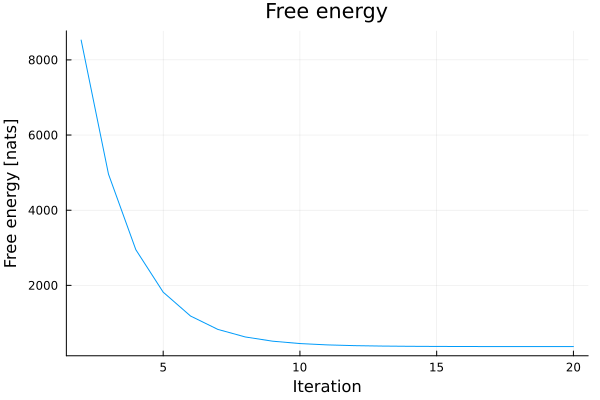

In [25]:
# drop first iteration, which is influenced by the `initmessages`
plot(2:20, results.free_energy[2:end], title="Free energy", xlabel="Iteration", ylabel="Free energy [nats]", legend=false)

He sees that in the presence of more noise the inference result is more uncertain about the actual values for $a$ and $b$ parameters.

John samples $a$ and $b$ and plot many possible regression lines on the same plot:

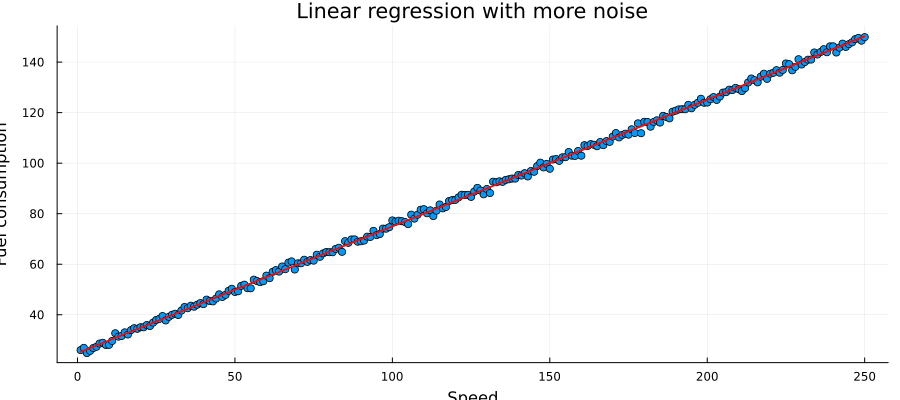

In [26]:
as = rand(results.posteriors[:a], 100)
bs = rand(results.posteriors[:b], 100)
p = scatter(x_data, y_data, title = "Linear regression with more noise", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")
for (a, b) in zip(as, bs)
    global p = plot!(p, x_data, a .* x_data .+ b, alpha = 0.05, color = :red)
end

plot(p, size = (900, 400))